# Tutorial 3: Spatial domain-specific highly variable gene identification  on human breast cancer FFPE tissues)
Here we present our re-analysis of Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix sample of the human breast cancer FFPE tissues dataset.

This tutorial demonstrates how to identify domain-specific SVGs on 10x Xenium data using STABox-STAMarker. The processed data are available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE243280. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import torch
from stabox.model import STAGATE
from stabox.model import STAMarker
from stabox.model._utils import Cal_Spatial_Net, Stats_Spatial_Net
from stabox.model import STAligner
import glob
from scipy.sparse import issparse, csr_matrix
from stabox.pl.utils import Cal_Spatial_Net_new
import anndata as ad
import scipy.linalg
os.environ['R_HOME'] = "D:\\Users\\lqlu\\work\\software\\R-4.2.1"
os.environ['R_USER'] = "D:\\Users\\lqlu\\work\\software\\Anaconda\\envs\\STAKITS\\Lib\\site-packages\\rpy2"


D:\Users\lqlu\work\software\Anaconda\envs\STABox_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = sc.read_10x_h5(filename='D:\\Users\\lqlu\\work\\Data\\STABox_Data\\10X_Data\\10x Xenium\\Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5')
df = pd.read_csv('D:\\Users\\lqlu\\work\\Data\\STABox_Data\\10X_Data\\10x Xenium\\Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv')
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

D:\Users\lqlu\work\software\Anaconda\envs\STABox_env\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


------Calculating spatial graph...
The graph contains 1373756 edges, 167782 cells.
8.1877 neighbors per cell on average.


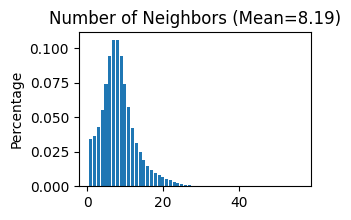

In [4]:
Cal_Spatial_Net(adata=adata,rad_cutoff=20)
Stats_Spatial_Net(adata)

In [5]:
stamarker = STAMarker(model_dir="./stabox/result/",
                      in_features=adata.shape[1], hidden_dims=[200, 30],
                      n_models=3, device=torch.device("cuda:0"))

In [ ]:
stamarker.train(adata, lr=1e-4, n_epochs=500, gradient_clip=5.0, use_net="Spatial_Net",
                resume=False, plot_consensus=True, n_clusters=10)

Starting training at status []...
------Stage 1: Autoencoders training...


Train autoencoder 2 Epoch: 499/500, Loss: 2.1091: 100%|█████████████████████████████████| 3/3 [06:34<00:00, 131.30s/it]

------Stage 2: Consensus labels generation...



Train autoencoder 2 Epoch: 499/500, Loss: 2.1091: 100%|█████████████████████████████████| 3/3 [06:34<00:00, 131.41s/it]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%



 25%|█████████████████████                                                               | 1/4 [01:27<04:22, 87.65s/it]

fitting ...
  |======================================================================| 100%



 50%|█████████████████████████████████████████▌                                         | 2/4 [03:19<03:23, 101.98s/it]

fitting ...
  |======================================================================| 100%



 75%|███████████████████████████████████████████████████████████████                     | 3/4 [04:33<01:29, 89.11s/it]

Compute consensus matrix. Elapsed: 266.26



In [ ]:
stamarker.predict(adata, use_net="Spatial_Net")

In [ ]:
output = stamarker.select_spatially_variable_genes(adata, use_smap="smap", alpha=1.5)